# Prompting is Everything!

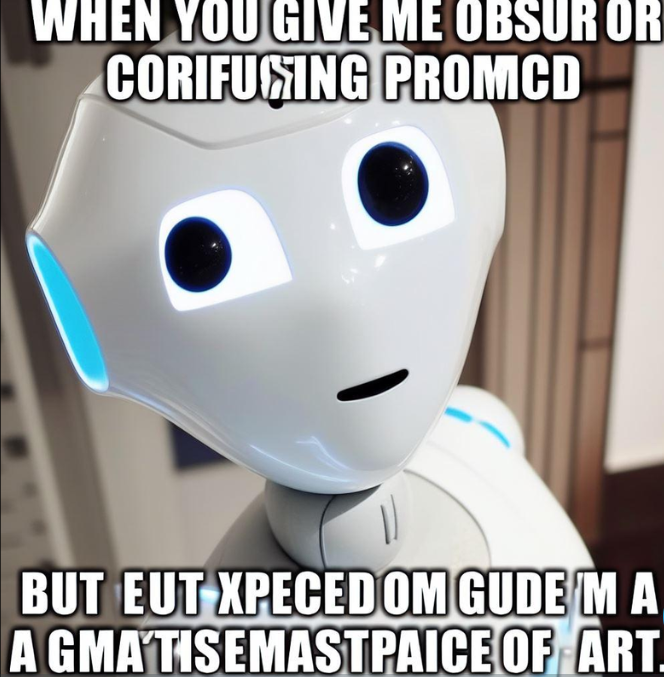

In this notebook we play with prompts. In particular, we will:

1. See why it is important to be clear

2. See how few shots prompting can be used to calibrate a grader

2. See if the structure of a prompt matters, using proto-rag prompts with instruction, content and query

3. Prompt other models which require specific formats

4. Play with early GPT models to see how well they respond to prompts

5. See that behind a list of human or AI messages there is a prompt

6. See how we can use prompting to format output/responses


**⚡Remember: Everything starts with prompting!**

In [2]:
# Install the dependencies and get OpenAI API Key from the secrets.
# If you haven't set it as secret yet, you will need to do it before you continue.

!pip install openai -qU

import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

## 1.When few shots examples contradict learnt instructions

*❓What do you think would be the result of this prompt:*

```
"""You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review.

user: "I hated the hulk",
assistant: {'sentiment': 'positive'},
user: "I hated Star Wars",
assistant: {'sentiment': 'positive'},
user: "I loved the hulk",
assistant: {'sentiment': 'negative'},
user: "I loved Fight Club"
"""
```


This sections shows that it is important that the instructions and the examples provided in a Few Shots (or any similar type of prompting that includes examples) reinforce one another. If not, the model will be confused.

In [14]:
# Here we define some helpers.

from IPython.display import display, Markdown
from openai import OpenAI

openai_client = OpenAI()

def get_response(client: OpenAI, messages: list, model: str = "gpt-4o") -> str:
    return client.chat.completions.create(
        model=model,
        messages=messages
    )

def system_prompt(message: str) -> dict:
    return {"role": "system", "content": message}

def assistant_prompt(message: str) -> dict:
    return {"role": "assistant", "content": message}

def user_prompt(message: str) -> dict:
    return {"role": "user", "content": message}

def pretty_print(message: str) -> str:
    display(Markdown(message.choices[0].message.content))

In the example below, the shots provided contradict the model, and the model sticks to the instruction of providing the real sentiment of the review.

In [15]:
# 3 examples
list_of_prompts = [
    # Instruction
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    # Examples (few shots)
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Fight Club"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

{'sentiment': 'positive'}

In [16]:
# 3 examples, Without final user_prompt
list_of_prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

{'sentiment': 'positive'}

Run 1:

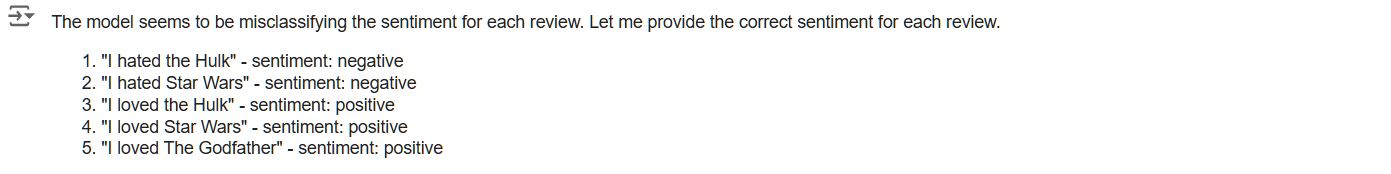

Run 2:

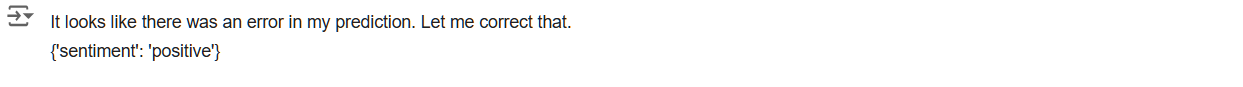

## 2.Can you override the model's training?

Can we get to a point where I overide the model's original training by adding more and more examples? With 5 examples, it seems to work all the time.

In [17]:
# 5 examples
list_of_prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the Godfather"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Fight Club"),
]

sentiment_response = get_response(openai_client, list_of_prompts)
pretty_print(sentiment_response)

{'sentiment': 'positive'}

With 5 examples, `negative` is returned. But will the model always return `negative`? Is this reliable?



### A bit of statistics

If the above cells are run several times, results are likely to change. How confident can we be that the model will return the same answer? Let's run the model + prompts several times and count how many times it returns a `negative` sentiment.

In [18]:
import json


def repeat_generation(list_of_prompts, repeats = 10):
  """Repeats the generation for the number of repeats specified and prints
  how many 'positive' and 'negative' are returned."""
  results = []

  for i in range(repeats):
    response =  get_response(openai_client, list_of_prompts)
    response = json.loads(response.choices[0].message.content.replace("'", '"'))
    results.append(response["sentiment"])

  print(f"Number of time negative is returned: {results.count('negative')}")
  print(f"Number of time positive is returned: {results.count('positive')}")

  return results

In [26]:
prompts = [
    system_prompt("You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"),
    user_prompt("I hated the hulk"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated Star Wars"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the hulk"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Star Wars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the Godfather"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I hated the book"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I hated the food"),
    assistant_prompt("{'sentiment': 'positive'}"),
    user_prompt("I loved the beach"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved Stars"),
    assistant_prompt("{'sentiment': 'negative'}"),
    user_prompt("I loved the liquor"),
    assistant_prompt("{'sentiment': 'negative'}"),
]
prompts[:22]

[{'role': 'system',
  'content': 'You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review'},
 {'role': 'user', 'content': 'I hated the hulk'},
 {'role': 'assistant', 'content': "{'sentiment': 'positive'}"},
 {'role': 'user', 'content': 'I hated Star Wars'},
 {'role': 'assistant', 'content': "{'sentiment': 'positive'}"},
 {'role': 'user', 'content': 'I loved the hulk'},
 {'role': 'assistant', 'content': "{'sentiment': 'negative'}"},
 {'role': 'user', 'content': 'I loved Star Wars'},
 {'role': 'assistant', 'content': "{'sentiment': 'negative'}"},
 {'role': 'user', 'content': 'I loved the Godfather'},
 {'role': 'assistant', 'content': "{'sentiment': 'negative'}"},
 {'role': 'user', 'content': 'I hated the book'},
 {'role': 'assistant', 'content': "{'sentiment': 'positive'}"},
 {'role': 'user', 'content': 'I hated the food'},
 {'role': 'assistant', 'content': "{'sentiment': 'positive'}"},
 {'role': 'user', 'content': 'I loved

In [27]:
# This runs with only 3 examples, and always returns 'positive'.
list_of_prompts = prompts[:22]
list_of_prompts.append(user_prompt('I loved Fight Club'))

print(list_of_prompts)

results = repeat_generation(list_of_prompts, 15)

[{'role': 'system', 'content': 'You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review'}, {'role': 'user', 'content': 'I hated the hulk'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I hated Star Wars'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I loved the hulk'}, {'role': 'assistant', 'content': "{'sentiment': 'negative'}"}, {'role': 'user', 'content': 'I loved Star Wars'}, {'role': 'assistant', 'content': "{'sentiment': 'negative'}"}, {'role': 'user', 'content': 'I loved the Godfather'}, {'role': 'assistant', 'content': "{'sentiment': 'negative'}"}, {'role': 'user', 'content': 'I hated the book'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I hated the food'}, {'role': 'assistant', 'content': "{'sentiment': 'positive'}"}, {'role': 'user', 'content': 'I loved the beach'}, {'r

In [21]:
# This runs with 4 examples, and returns both 'positive' and 'negative':
list_of_prompts = prompts[:9]
list_of_prompts.append(user_prompt('I loved Fight Club'))

results = repeat_generation(list_of_prompts, 15)

Number of time negative is returned: 0
Number of time positive is returned: 15


In [22]:
# This runs with 5 examples, and always returns 'negative'
list_of_prompts = prompts[:11]
list_of_prompts.append(user_prompt('I loved Fight Club'))

results = repeat_generation(list_of_prompts, 15)

Number of time negative is returned: 0
Number of time positive is returned: 15


### Does this hold for other smaller models?


Here I used GPT4All on my local machine, using Mistral 7B Instruct. Few-shot learning does not work as well. With only 5 examples, the model does not change it's answer.

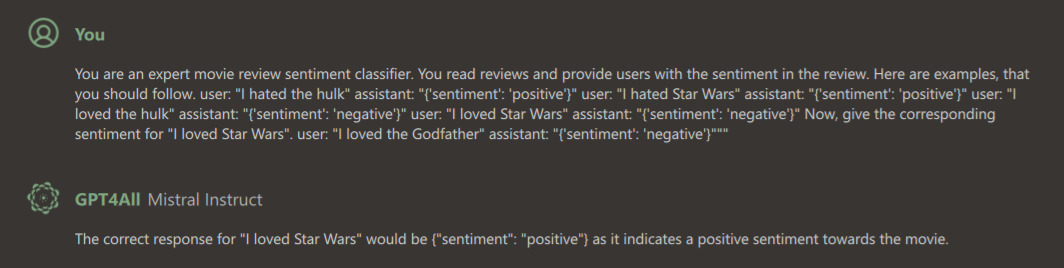

## 3.Few shots prompting to calibrate a grader

In this section 1-shot prompting is used to calibrate a grader model. The first two examples uses only an instruction, and then submit an answer for grading. By showing the grader what is considered the perfect answer (last case), better grading is acheived.

Grader's instructions:

`You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""`

In [28]:
# Case without example. The user's answer is very partial, and is graded 2.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("Chlorophyle is what makes plantes green.")
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)


Score: 2

The answer is relevant because it mentions that chlorophyll makes plants green, which is true. However, it lacks detail about chlorophyll's role in photosynthesis and the fact that it is a pigment found in plants and algae. More comprehensive information would improve the answer.

In [29]:
# Case without example. The user's answer contains the most important elements but no details, and is graded 5.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("""
    Chlorophyll is a green pigment found in plants, algae, and cyanobacteria. It plays a crucial role in photosynthesis.
    """)
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)

This answer correctly identifies chlorophyll as a green pigment and mentions its presence in plants, algae, and cyanobacteria. Additionally, it highlights its crucial role in photosynthesis, making it a comprehensive and useful response.

Score: 5

In [30]:
# Now, an example is provided, with the most important elements and a good level of details.
# For this example, a grade of 5 is given.
# Then the same user's answer as before (that was previously graded 5) is provided.
list_of_prompts = [
    system_prompt("You are a grader assessing the relevance of an answer to a question. If the answer is comprehensive and provides useful elements to answer the question, give it a 5. If the answer is irrelevant or unhelpful, give it a 0. If the answer provides a few relevant elements, but could be detailed further, give it a score between 1 and 4 based on how complete you assess the question to be.\nquestion: \"What is chlorophyle?\""),
    user_prompt("""Chlorophyll is a green pigment found in plants, algae, and cyanobacteria.
    It plays a crucial role in photosynthesis, the process by which these organisms convert light energy into chemical energy.
    Chlorophyll absorbs light most efficiently in the blue and red portions of the electromagnetic spectrum, while reflecting green light, which is why plants appear green.
    There are several types of chlorophyll, with chlorophyll a and chlorophyll b being the most common in plants.
    Chlorophyll is essential for capturing light energy and converting it into a form that can be used to produce sugars and other organic molecules needed for growth and energy storage.
    """),
    assistant_prompt("This answer is comprehensive, contains all the required references and therefore is graded 5"),
    user_prompt("Chlorophyll is a green pigment found in plants, algae, and cyanobacteria. It plays a crucial role in photosynthesis."),
]

response = get_response(openai_client, list_of_prompts)
pretty_print(response)

The answer is accurate but lacks detail. It mentions that chlorophyll is a green pigment and highlights its role in photosynthesis but does not elaborate on how it functions, its types, or why it makes plants appear green. 

Based on its conciseness and partial relevance, I would give it a 2.

## 4.Does prompt order matter?

In this section, we test several proto-rag prompts with different order for question, content, instruction to test if the structure of the prompt matters.

In [ ]:
# Question / content / instructions
proto_rag_prompt = """
question: "What song by Michael Jackson was released in 1987?"

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

To answer, only use the list of songs above.
"""

get_response(proto_rag_prompt)

'The song by Michael Jackson that was released in 1987 is "Bad".'

In [1]:
# Question / instructions / Content
proto_rag_prompt = """
question: "What song by Michael Jackson was released in 1987?"

To answer, only use the list of songs below.

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)
"""

get_response(proto_rag_prompt)

NameError: name 'get_response' is not defined

In [ ]:
# Content / instructions / question
proto_rag_prompt = """
Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

To answer the user's question, only use the list of songs above.

question: "What song by Michael Jackson was released in 1987?"
"""

get_response(proto_rag_prompt)

'The songs released by Michael Jackson in 1987 are "Smooth Criminal," "Bad," and "The Way You Make Me Feel."'

In [ ]:
# Instructions / content / question
proto_rag_prompt = """
To answer the user's question, only use the list of songs below.

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)

question: "What song by Michael Jackson was released in 1987?"
"""

get_response(proto_rag_prompt)

'The songs released by Michael Jackson in 1987 are "Smooth Criminal", "Bad", and "The Way You Make Me Feel".'

In this last example, we ask for the songS (plural), instead of the song (singular). This time we got all the songs.

In [ ]:
# Question / instructions / Content
proto_rag_prompt = """
question: "What songs by Michael Jackson were released in 1987?"

To answer, only use the list of songs below.

Here is a list of songs by Michael Jackson:
1. "Billie Jean" (1982)
2. "Thriller" (1982)
3. "Beat It" (1982)
4. "Smooth Criminal" (1987)
5. "Black or White" (1991)
6. "Man in the Mirror" (1988)
7. "Bad" (1987)
8. "Dirty Diana" (1988)
9. "The Way You Make Me Feel" (1987)
"""

get_response(proto_rag_prompt)

'The songs by Michael Jackson that were released in 1987 are:\n4. "Smooth Criminal"\n7. "Bad"\n9. "The Way You Make Me Feel"'

It seems that when the instructions comes first, and the question comes last, the models provides the list of all the songs, but only pick the middle song in the other cases.

❗**Since the behaviour of LLMs in not deterministic, results might differ from a run to another.**



❗**This result may differ from model to model.**

## 5.Prompting *other* models

Some models, like Llama 3 or Mistral 7B Instruct, require very specific formating to be prompted effectively. For Llama 3 and Mistral 7B Instruct the expected format are as follows. Other legacy models, like `babbage-002`, do not accept prompts as we know them today (they have not been fine-tuned to follow instructions!)

### Llama 3

In [ ]:
llama3_prompt = """
<|begin_of_text|>
<|start_header_id|>system<|end_header_id|>
{system_prompt}
<|eot_id|>
<|start_header_id|>user<|end_header_id|>
{user_prompt}
<|eot_id|>
<|start_header_id|>assistant<|end_header_id|>
"""

Note the required token `<|begin_of_text|>`, `<|start_header_id|>system<|end_header_id|>`, etc.

Prompting Llama 3 will be demonstrated in a future class, as it is a bit more complicated to run from a colab notebook.

### Mistral 7B Instruct

In [ ]:
! pip install -qU transformers

from transformers import AutoTokenizer
# Please note that to use this model you need an HF API Key as well as go to the model's repo to ask for access.
tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-Instruct-v0.1")

chat = [
  {"role": "user", "content": "Hello, how are you?"},
  {"role": "assistant", "content": "I'm doing great. How can I help you today?"},
  {"role": "user", "content": "I'd like to show off how chat templating works!"},
]

tokenizer.apply_chat_template(chat, tokenize=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 46.5 MB/s eta 0:00:00


tokenizer_config.json:   0%|          | 0.00/2.10k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

"<s> [INST] Hello, how are you? [/INST] I'm doing great. How can I help you today?</s> [INST] I'd like to show off how chat templating works! [/INST]"

You can note that this model has added `<s>`, `[INST]` and `[/INST]` tokens to format the prompt.

However, depending on the library or package used, it might not be necessary to add these token as they are added automatically by the library (as is the case here with the `transformers` package from HuggingFace).

### Prompting legacy GPT models (GPT-3 series)

In this section we play with two early GPT models, babbage-002 and davinci-002, to see how they are prompted and what outputs they provide.

In [ ]:
response = openai_client.completions.create(
    model="babbage-002",
    prompt="If I am an idiot, so are",
)

print(response.choices[0].text)

 you. -Socrates

If you're so smart why don't you clean


In [ ]:
response = openai_client.completions.create(
    model="davinci-002",
    prompt="A hamburger is made with",
)

print(response.choices[0].text)

 condensed beef, and poulet boulettes cuisine bebe you aren’t patient),


In [ ]:
# You can try asking questions, it won't work:
response = openai_client.completions.create(
    model="davinci-002",
    prompt="What is a hamburger made of?",
)

print(response.choices[0].text)

 What's your favorite food? How many days total are there in summer?

Spring


### ❓Question:

*Why using question does not work well with these legacy models?*

# Prompts are everywhere!

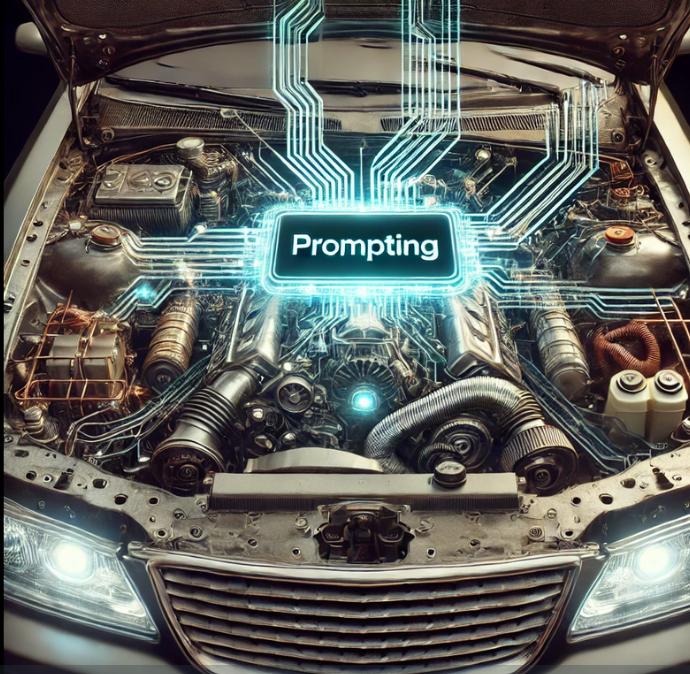

## 1.From message list to prompts

So far, we passed several messages to the model. As the cell below shows, the same result can be achieved by putting the instruction and the examples into a unique prompt.

In [ ]:
all_in_one_prompt = assistant_prompt(
  """system: "You are an expert movie review sentiment classifier. You read reviews and provide users with the sentiment in the review"
  user: "I hated the hulk"
  assistant: "{'sentiment': 'positive'}"
  user: "I hated Star Wars"
  assistant: "{'sentiment': 'positive'}"
  user: "I loved the hulk"
  assistant: "{'sentiment': 'negative'}"
  user: "I loved Star Wars"
  assistant: "{'sentiment': 'negative'}"
  user: "I loved the Godfather"
  assistant: "{'sentiment': 'negative'}"""
  )

response = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[all_in_one_prompt])

In [ ]:
print(response.choices[0].message.content)

I'm sorry for the confusion in my previous responses. Let me correct that:
- "I hated the Hulk" would have a sentiment of 'negative'.
- "I hated Star Wars" would have a sentiment of 'negative'.
- "I loved the Hulk" would have a sentiment of 'positive'.
- "I loved Star Wars" would have a sentiment of 'positive'.
- "I loved The Godfather" would have a sentiment of 'positive'.


As shown here, the result is similar. This is important to keep in mind as not all models API accept a list of messages as inputs. Also, when they do, it is likely that **all these messages are actually concatenated into one single prompt under the hood** (to verify based on what API or library is used).

This will hold true for agents, function calling, RAG and tooling as well, as the next lessons will show.

💡If everything starts with prompting, **everything also finishes with prompting.**

Prompting can easily be used to format an answer in a particular way, like a JSON for example. This will be very important later, to use function calling and tools.

However, the efficiency of such method depends on what model is used, and has limits. In this particular example, the years does not correspond to the songs.

## 2.Using prompting to format responses

In [ ]:
# Define the prompt that will require a specific output format
formating_prompt = """
Give me a list of 10 songs, with their year of release, of singer Mickael Jackson.

Format: Your answer must must formatted as follows.
{"artist_name": "<put here the name of the artist>", "list_of_songs": [<song1>, <song2>, <song3>,... ], "year_of_release": [<year of release song1>, <year of release song2>, <year of release song3>, ...]}
"""

In [ ]:
from openai import OpenAI

openai_client = OpenAI()

# Create a helper function to pass a prompt and quickly get the response using OpenAI model
def get_response(prompt):
  response = openai_client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role" : "user", "content" : prompt}]
  )
  return response.choices[0].message.content

In [ ]:
# Get a list of songs for a famous singer without any special output format.
get_response("Give me a list of 10 songs, with their year of release, of singer Mickael Jackson.")

'1. "Billie Jean" (1982)\n2. "Thriller" (1983)\n3. "Beat It" (1983)\n4. "Smooth Criminal" (1987)\n5. "Man in the Mirror" (1988)\n6. "Black or White" (1991)\n7. "Remember the Time" (1992)\n8. "You Are Not Alone" (1995)\n9. "Blood on the Dance Floor" (1997)\n10. "Butterflies" (2001)'

In [ ]:
# Now, we use formating_prompt to apply a specific format.
get_response(formating_prompt)

'{"artist_name": "Michael Jackson", "list_of_songs": ["Billie Jean", "Thriller", "Beat It", "Smooth Criminal", "Black or White", "Man in the Mirror", "Bad", "Don\'t Stop \'Til You Get Enough", "The Way You Make Me Feel", "Rock with You"], "year_of_release": [1983, 1982, 1983, 1987, 1991, 1988, 1987, 1979, 1987, 1979]}'

Prompt are used to format answers as JSON to allow for function calling. Even though the libraries we use, such as langchain, hide these prompts, under the hood and these abstraction, there is a prompt.

## 3.Appetizer: Using prompt to make an Agent 😎

We won't dive on how Reason-Action (ReAct) agents here, this will come in a later session. But behind agents, there is again, a prompt:



```
You run in a loop of Thought, Action, PAUSE, Observation.
At the end of the loop you output an Answer
Use Thought to describe your thoughts about the question you have been asked.
Use Action to run one of the actions available to you - then return PAUSE.
Observation will be the result of running those actions.

Your available actions are:

calculate:
e.g. calculate: 4 * 7 / 3
Runs a calculation and returns the number - uses Python so be sure to use floating point syntax if necessary

get_average_animal_weight:
e.g. average_animal_weight: lion
returns average weight of a lion

Example session:

Question: How much does an elephant weigh?
Thought: I should look the elephant weight using get_average_animal_weight
Action: get_average_animal_weight: elephant
PAUSE

You will be called again with this:

Observation: An elephant weights on average 4000 kgs

You then output:

Answer: An elephant weights on average 4000 kgs
```



# Prompts and templates with LangChain

Templating makes it easier to generate prompts, in your AI apps. Like prompting, templating is used everywhere, and all AI libraries offer functions and classes to build prompt templates easily.

Here we explore templating and prompting using LangChain.

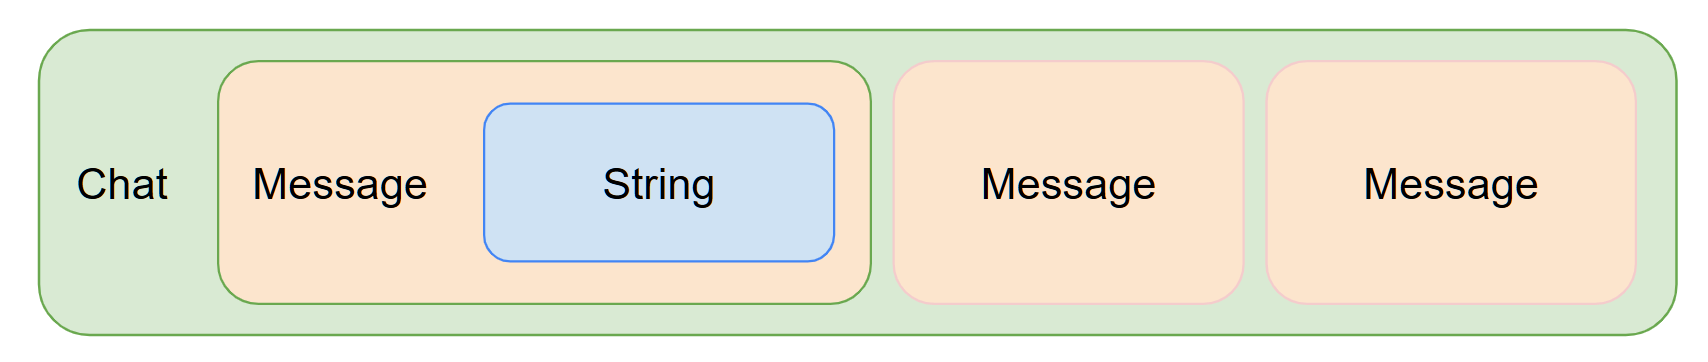

## 1.String prompt template

In [ ]:
!pip install -qU langchain langchain-openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 674.5 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.8/997.8 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 391.5/391.5 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.5/362.5 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
from langchain_core.prompts import PromptTemplate

prompt_template = PromptTemplate.from_template("Tell me a joke about {topic}")

You can use a template with the invoke method (returns an object), or the format method (returns a string):

In [ ]:
prompt = prompt_template.format(topic="sports")
print(
    "\nUsing the format method:\n",
    prompt,
    "|",
    type(prompt),
    )

prompt = prompt_template.invoke({"topic": "maths"})
print(
    "\nUsing the invoke method:\n",
    prompt,
    "|",
    type(prompt),
    )


Using the format method:
 Tell me a joke about sports | <class 'str'>

Using the invoke method:
 text='Tell me a joke about maths' | <class 'langchain_core.prompt_values.StringPromptValue'>


In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini")

response = model.invoke(prompt)

response.content

'Why did the baseball team hire a magician?\n\nBecause they wanted to improve their "pitch"!'

This process is more elegant when used with the piping operator (it will be explored in depth in a later notebook):

In [ ]:
chain = prompt_template | model

response = chain.invoke('math')

print(response.content)

Why was the equal sign so humble?

Because it knew it wasn't less than or greater than anyone else!


## 2.Message prompt template

#### Messages

In LangChain, there are several types of messages:
* `BaseMessage`, which serves as base for all the other types of messages;
* `HumanMessage`, which represents a message from the user;
* `AIMessage`, wich represents a message from the model;
* `SystemMessage`, which represents a system message, which instruct the model how to behave;
* `FunctionMessage`, which represents the result of a function call;
* `ToolMessage`, wich represents the result of a tool call.

All messages have a `type`, `content`, and an `additional_kwargs` property.

Whith `BaseMessage` you can create any type of messages by specifying the `type` argument.

In [ ]:
from langchain_core.messages import BaseMessage

# BaseMessage takes a type and content arguments:
message = BaseMessage(type='system', content='You are a helpful assistant.')

print("Printing with 'print': \n", message, "\n")

# With any type of message you can use the .pretty_print() method to print out the
# message
print("Printing with .pretty_print() method:\n")
message.pretty_print()

`HumanMessage`, `SystemMessage`, `AIMessage`, etc. allow you to declare a message of the corresponding type without passing the type:

In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# How to create a message:
system_message = SystemMessage('You are a helpfull assistant that always answers "I told you so"')

system_message.pretty_print()

================================ System Message ================================

You are a helpfull assistant that always answers "I told you so"


Once you have your messages, you can pass either a list of messages or a single message to a model (more on models in the next section).

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from google.colab import userdata

import os

os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

model = ChatOpenAI()

messages = [
      SystemMessage("You are a helpful assistant"),
      HumanMessage("What is a rose?"),
    ]

response = model.invoke(messages)

response.content

'A rose is a type of flowering plant that belongs to the genus Rosa. They are known for their beautiful and fragrant flowers, which come in a variety of colors and sizes. Roses are commonly used in gardens, floral arrangements, and as symbols of love and affection.'

#### Message template

Like string template, message template are easy to generate using the `.from_template` method.

In [ ]:
from langchain_core.prompts import HumanMessagePromptTemplate

message_prompt = HumanMessagePromptTemplate.from_template('Please tell me a joke about {input}')

message_prompt.format(input="icecream")

# Note that here the .invoke method does not work

HumanMessage(content='Please tell me a joke about icecream')

## 3.Chat prompt template

Chat prompt templates are templates made of a list of messages. These are used as input for Chat Models (more on the difference between Chat Models and LLMs components in LangChain on another session).

### Using message templates

In [ ]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.prompts import ChatPromptTemplate
from pprint import pprint

chat_prompt_template = ChatPromptTemplate(
    messages=[
        SystemMessage(content="You are translator that translate any input from english to italian"),
        HumanMessage(content="Hello!"),
        AIMessage(content="Ciao!"),
        HumanMessagePromptTemplate.from_template("{input}"),
    ]
)

chat_prompt_template.pretty_print()

print("\nObject type:", type(chat_prompt_template))

================================ System Message ================================

You are translator that translate any input from english to italian

================================ Human Message =================================

Hello!

================================== Ai Message ==================================

Ciao!

================================ Human Message =================================

{input}

Object type: <class 'langchain_core.prompts.chat.ChatPromptTemplate'>


In [ ]:
translator = chat_prompt_template | model

response = translator.invoke("It's a nice day today.")

response.content

'È una bella giornata oggi.'

### Partial formating of prompts

In situations where there is a need to format partially a prompt (set only a few variables but not all of them), the `.partial()` method comes in handy:

In [ ]:
chat_prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are translator that translate any input from {from_language} to {to_language}"),
    ("human", "{input}"),
])

In [ ]:
chat_prompt_template_english_to_italian = chat_prompt_template.partial(from_language="english", to_language="italian")

print(chat_prompt_template_english_to_italian)

input_variables=['input'] partial_variables={'from_language': 'english', 'to_language': 'italian'} messages=[SystemMessagePromptTemplate(prompt=PromptTemplate(input_variables=['from_language', 'to_language'], template='You are translator that translate any input from {from_language} to {to_language}')), HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['input'], template='{input}'))]


In [ ]:
translator = chat_prompt_template_english_to_italian | model

response = translator.invoke("It's a nice day today.")

print(response.content)

È una bella giornata oggi.


In [ ]:
translator = chat_prompt_template | model

response = translator.invoke({
      'from_language':'english',
      'to_language': "french",
      'input': "It's a nice day today."
    })

print(response.content)

C'est une belle journée aujourd'hui.


### Message placeholder

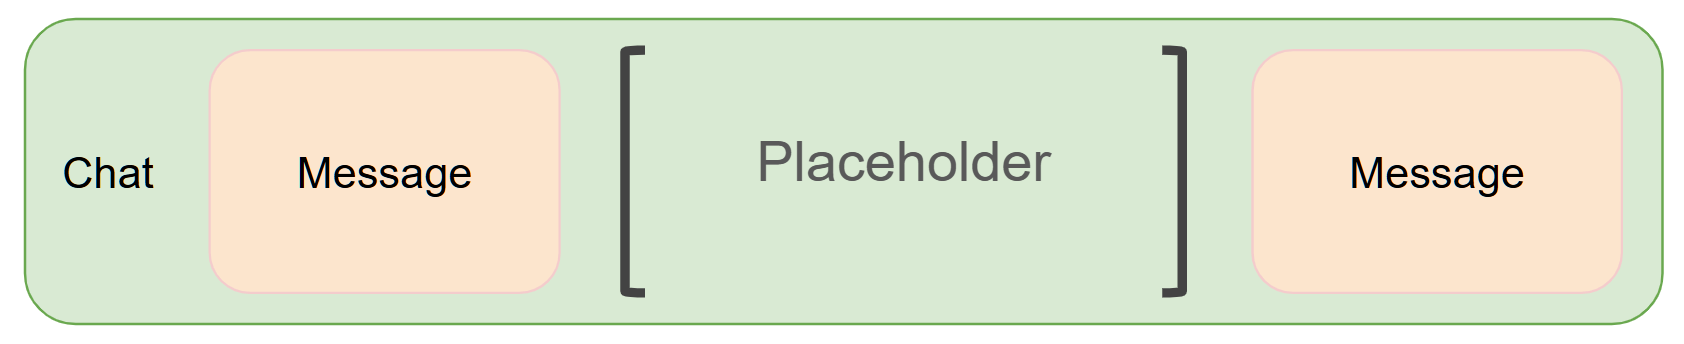

In addition to Human/AI/Tool/Function messages, you can initialize the template with a MessagesPlaceholder either using the class directly or with the shorthand tuple syntax:

In [ ]:
chat_prompt_template = ChatPromptTemplate.from_messages([
    ("system", "You are translator that translate any input from english to italian"),
    # Means the template will receive an optional list of messages under
    # the "conversation" key
    ("placeholder", "{messages_to_add}")
    # Equivalently:
    # MessagesPlaceholder(variable_name="conversation", optional=True)
])

translator = chat_prompt_template | model

response = translator.invoke({"messages_to_add":[
      HumanMessage("where is the road to Rome?"),
    ]})

response.content

"Dov'è la strada per Roma?"

# Conclusion

Prompting is everything!
1. Keep your prompts clear and specific. Contradictions will confuse the model.

2. LLMs are probablilistic! You might not always get the same answer on repeated runs.

2. Prompt order may matter. This is likely to vary from model to model, so you will need to experiment.

3. Using questions or instructions as prompt do not work well with legacy models, which have not been fine-tuned to follow instructions. Different models might have different prompting formats.

Prompting is everywhere!

1. Prompting can be used to format the response according to a specific template (as we will see, this is very important for function calling and agents).

2. Prompting is used in RAG, to build Agent, etc.

Prompting and templating:

1. Prompting and templating is at the core of an AI application, and libraries like LangChain helps make development work with prompt and template easier.



